# Linear Classification

revision: dcfbda7

In [102]:
import matplotlib.pyplot as plt
# PREAMBLE
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import check_grad

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Classifying Rock Types

Our next real world example will be from geology.
More precisely from *rock physics*, which studies the relation between physical and elastic properties of rocks and is the basis of quantitative seismic interpretation.
In this scenario, we got the following data set with the task to distinguish between shale and sand rock types.
As sample of the data looks as follows.

In [103]:
# load all data
df = pd.read_csv('rocktypes.csv', sep=' ')
print(df)

       impedance  velocity   type  outlier
0    5380.910348  2.450096  shale   normal
1    5376.786604  2.441064  shale   normal
2    5387.723093  2.461310  shale   normal
3    5404.297438  2.504548  shale   normal
4    5423.064317  2.526493  shale   normal
..           ...       ...    ...      ...
426  5599.979269  2.299732   sand   normal
427  5936.401016  2.471510   sand   normal
428  5853.235117  2.407090   sand   normal
429  5250.000000  2.150000  shale  outlier
430  6200.000000  2.400000  shale  outlier

[431 rows x 4 columns]


In order to feed the data to an algorithm, we have to convert the string 'type' to a numerical label ($\{-1, +1\}$ in this case).
Create a new column 'label' which contains the value 1 if the type is 'sand' and -1 otherwise.

<AxesSubplot:xlabel='impedance', ylabel='velocity'>

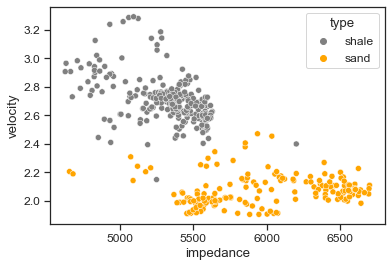

In [104]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, x='impedance', y='velocity', hue='type', data=df, palette=dict(sand='orange', shale='gray'))

In [105]:
df["label"] = [-1 if x == "sand" else 1 for x in df["type"]]

In [106]:
# assert that the label column is correct
np.testing.assert_array_equal(np.sum(df['label'] == +1), 258)
np.testing.assert_array_equal(np.sum(df['label'] == -1), 173)

### Exploring the data

Before starting on any task, it is often useful to understand the data by visualizing it.

<AxesSubplot:xlabel='impedance', ylabel='velocity'>

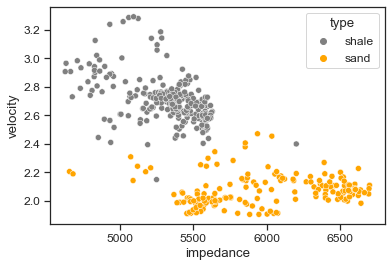

In [107]:
_, ax = plt.subplots()
sns.scatterplot(ax=ax, x='impedance', y='velocity', hue='type', data=df, palette=dict(sand='orange', shale='gray'))

### Feature Scaling

1. Scale the columns `df['impedance']` and `df['velocity']` such that they have zero mean and unit variance.
Do not overwrite the columns, but create new ones as `df['impedance normalized']` and `df['velocity normalized']`.
2. Add a bias column `df['bias']`.
3. Plot the normalized data.

In [108]:
# Insert your code here.
df['impedance normalized'] = (df['impedance']-np.mean(df['impedance']))/np.std(df['impedance'])
df['velocity normalized'] = (df['velocity']-np.mean(df['velocity']))/np.std(df['velocity'])
df['bias'] = 1

In [109]:
df['impedance normalized'] = (df['impedance'] - df['impedance'].mean()) / df['impedance'].std()
df['velocity normalized'] = (df['velocity'] - df['velocity'].mean()) / df['velocity'].std()
df['bias'] = 1

<AxesSubplot:xlabel='impedance normalized', ylabel='velocity normalized'>

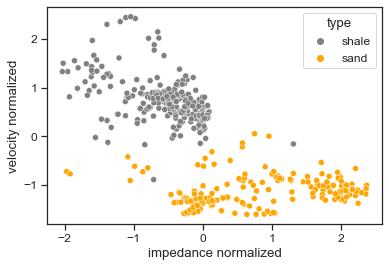

In [110]:
_, ax = plt.subplots()
sns.scatterplot(ax=ax, x='impedance normalized', y='velocity normalized', hue='type', data=df, palette=dict(sand='orange', shale='gray'))

In [111]:
# export pandas dataframe to numpy array
X = df[['bias', 'impedance normalized', 'velocity normalized', ]].values
y = df['label'].values
(n, d) = X.shape

print(f"Dimensions X: {X.shape}, y: {y.shape}")
np.testing.assert_array_equal(X.shape, (431, 3))
np.testing.assert_array_equal(y.shape, (431,))
np.testing.assert_array_almost_equal(X[0, :], [1., -0.4344, -0.0095], decimal=4)

Dimensions X: (431, 3), y: (431,)


In [112]:
# Open losses.py and implement the function logistic_loss
from mlis.classification.losses import logistic_loss

np.testing.assert_array_almost_equal(logistic_loss(0.4, 1), 0.513, decimal=3)
np.testing.assert_array_almost_equal(logistic_loss(0.4, -1), 0.913, decimal=3)
np.testing.assert_array_almost_equal(logistic_loss(np.array([-2.1, 0.2, 1.3]), np.array([1, -1, 1])),
                                     [2.2155, 0.7981, 0.241], decimal=3)

In [113]:
# Open linearclassification.py and implement the function h (can be copied from linear regression)
from mlis.classification.linearclassification import h

w = np.array([2, 3, -1])
np.testing.assert_array_almost_equal(h(w, X)[:3], [0.71, 0.71, 0.72], decimal=2)

In [114]:
# Open logisticregression.py and implement the function J
from mlis.classification.logisticregression import J

w = np.array([2, 3, -1])
np.testing.assert_array_almost_equal(J(w, X, y), 3.0116, decimal=4)

### Implementing gradient descent

Now that we have the hypothesis and the cost function we can implement the gradient descent routine. First, write a function $\nabla J(w)$ which returns the gradient of the cost function. The gradient is just a vector with all the partial derivatives
$$
\nabla J(w) = \bigg(\frac{\partial J(w)}{\partial w_1} , \dotsc, \frac{\partial J(w)}{\partial w_n} \bigg)
$$

In [115]:
# Open logisticregression.py and implement the function dJ
from mlis.classification.logisticregression import dJ

w = np.array([2, 3, -1])
assert dJ(w, X, y).shape == (3,)  # we expect a vector of size (3,)
np.testing.assert_almost_equal(check_grad(J, dJ, w, X, y), 0.0, decimal=3)

In [116]:
# Open linearclassification.py and implement the function gradientDescent (can be copyied from linear regression)
from mlis.classification.linearclassification import gradientDescent

w0 = [1, 1, 1]  # initial weights
eta = 0.05  # learning rate η
iters = 1000  # number of iterations

ws = gradientDescent(dJ, X, y, w0, eta, iters)
# the last entry contains the final parameters found by gradient decent
print(f"best weights w: {ws[-1]}")

# testing the correctness of gradientDescent
np.testing.assert_array_almost_equal(ws[-1], [0.998, -0.9523, 3.6905], decimal=3)  # test optimal weights

best weights w: [ 0.99799169 -0.95228297  3.6905252 ]


In [117]:
# Open losses.py and implement zero_one_loss
from mlis.classification.losses import zero_one_loss

np.testing.assert_array_almost_equal(zero_one_loss(0.4, 1), 0, decimal=3)
np.testing.assert_array_almost_equal(zero_one_loss(0.4, -1), 1, decimal=3)
np.testing.assert_array_almost_equal(zero_one_loss(np.array([-2.1, 0.2, 1.3, 1.3]), np.array([1, -1, 1, -1])),
                                     [1, 1, 0, 1], decimal=3)

### Verifying Gradient Descent

A good way to verify that gradient descent is working correctly is to look at the values $J(w)$ and check that it is decreasing with each step.
Compare the following plot with figure 3.6 on page 18

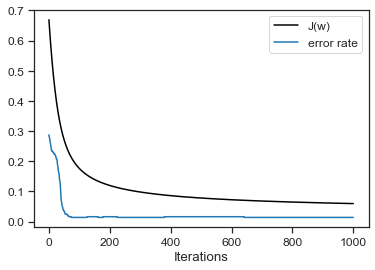

In [118]:
costs = [J(w, X, y) for w in ws]
errorrate = [np.mean(zero_one_loss(h(w, X), y)) for w in ws]

_, ax = plt.subplots()
ax.plot(np.arange(len(costs)), costs, 'k', label='J(w)')
ax.plot(np.arange(len(errorrate)), errorrate, label='error rate')
ax.set_xlabel('Iterations')
ax.legend()

We use the final parameters to plot the linear fit. Compare this to figure 3.7 on page 19.

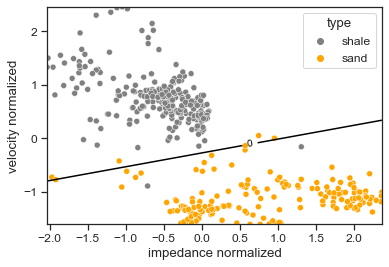

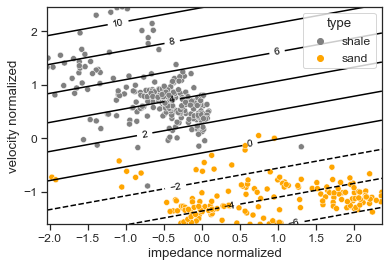

In [119]:
def plot_fit(h, w, levels=[0]):
    x_range = df['impedance normalized'].min(), df['impedance normalized'].max()
    y_range = df['velocity normalized'].min(), df['velocity normalized'].max()
    grid = 100
    xx, yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid), np.linspace(y_range[0], y_range[1], grid))
    XY = np.array([np.ones((grid * grid,)), np.ravel(xx), np.ravel(yy)]).T
    P = h(w, XY).reshape(grid, grid)

    _, ax = plt.subplots()
    sns.scatterplot(ax=ax, x='impedance normalized', y='velocity normalized', hue='type', data=df, palette=dict(sand='orange', shale='gray'))
    cn = ax.contour(xx, yy, P, colors='k', levels=levels)
    ax.clabel(cn, inline=1, fontsize=10)


plot_fit(h, ws[-1])
plot_fit(h, ws[-1], levels=10)

### Probabilistic Prediction

Implement the logistic function
$$
\sigma(z) = \frac{1}{1+\exp(-z)}
$$
in order to make probabilistic prediction.
Compare the result to figure 3.8 on page 19

In [120]:
# Open losses.py and implement the logistic function
from mlis.classification.losses import logistic

np.testing.assert_array_almost_equal(logistic(np.array([0.1, 8, -2])), [0.525, 1., 0.119], decimal=3)

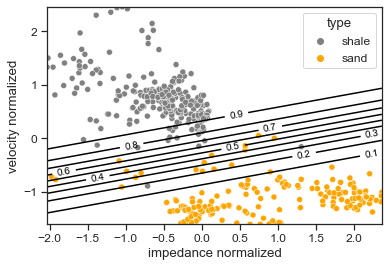

In [121]:
plot_fit(lambda w, X: logistic(h(w, X)), ws[-1], levels=10)

# Linear Support Vector Machine

In this section we implement a linear support vector machine using the hinge loss, but without the regularization term (we will discuss this in the next chapters):

\begin{align*}
	l_{\text{hinge}}(h(x), y)
	 & = \max \{0, 1-y\cdot h(x)\}
\end{align*}

The objective is then

\begin{equation*}
J(w) = \frac{1}{m} \sum_{i=1}^m \max \{0, 1-y\cdot h(x)\}
\end{equation*}

In [122]:
# Open svm.py and implement the svm objective J and gradient dJ
from mlis.classification.svm import J, dJ

w = np.array([2, 3, -1])
assert dJ(w, X, y).shape == (3,)  # we expect a vector of size (3,)
np.testing.assert_almost_equal(check_grad(J, dJ, w, X, y), 0.0, decimal=3)

optimal weights w: [ 0.73085847 -0.45435616  3.3869717 ]


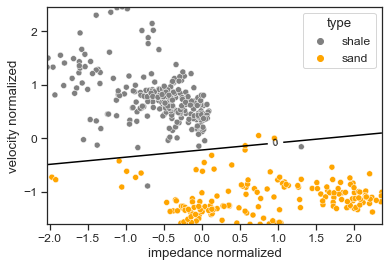

In [123]:
w0 = np.zeros(3)  # initial weights
eta = 1  # learning rate
iters = 200  # number of iterations

ws = gradientDescent(dJ, X, y, w0, eta, iters)
print(f"optimal weights w: {ws[-1]}")

plot_fit(h, ws[-1])

optimal weights w: [ 0.73085847 -0.45435616  3.3869717 ]


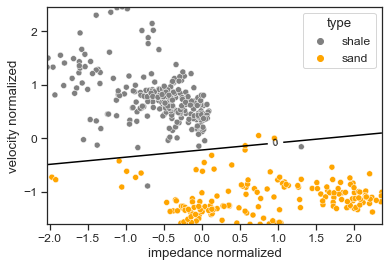

In [124]:
w0 = np.zeros(3)  # initial weights
eta = 1  # learning rate
iters = 200  # number of iterations

ws = gradientDescent(dJ, X, y, w0, eta, iters)
print(f"optimal weights w: {ws[-1]}")

plot_fit(h, ws[-1])

# Loss Functions

In [125]:
# Open losses.py and implement the logistic_loss and hinge_loss
from mlis.classification.losses import logistic_loss, hinge_loss

y = np.array([-1, -1, 1, 1])
yhat = np.array([-2, 3, -4, 1])

np.testing.assert_array_almost_equal(logistic_loss(yhat, y), [0.127, 3.049, 4.018, 0.313], decimal=3)
np.testing.assert_array_almost_equal(hinge_loss(yhat, y), [0., 4., 5., 0.], decimal=3)